In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from sqlalchemy import create_engine
import numpy as np
import json
import ast
from pandas import json_normalize
from collections import Counter
from IPython.display import Image, display
import streamlit as st

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway, chi2_contingency, ttest_ind
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score

In [ ]:
# connection_string = st.secrets["DB_CONNECTION_STRING"]
# engine = create_engine(connection_string)

# with engine.connect() as conn:
#     print("Connect to DB Supabase")

# 

# Importing case study data into Supabase

In [ ]:
# excel_name = "Study Case DA.xlsx"
# sheets = pd.read_excel(excel_name, sheet_name=None)

# print("Daftar worksheet:", list(sheets.keys()))

In [ ]:
# for sheet_name, df in sheets.items():
#     table_name = sheet_name.lower().replace(" ", "_")

#     print(f"Upload worksheet '{sheet_name}' to '{table_name}'...")

#     # Upload to Supabase
#     df.to_sql(table_name, engine, if_exists='replace', index=False)
    
# print("Done")


The analysis is strictly limited to performance and competencies data from the most recent year (2025) based on a critical analytical decision:

1. **Ensuring Relevance (Recency):** The goal is to build a **Success Formula**. Performance patterns and job demands often change, and using the most recent data (2025) ensures the resulting formula reflects the **current, most relevant** criteria for success.

2. **Mitigating Data Quality Issues:** Focusing on a single year eliminates major inconsistencies found in the historical data, specifically:

    **- Inconsistent Tenure:** The work_duration_months variable was found to be static and inconsistent when compared with historical rating years (e.g., 7 months tenure appearing on a 2022 record).

    ![Deskripsi gambar](year%20inconsistency.png)


    **- Data Duplication:** Restricting the data prevents the inflation of the sample size and avoids statistical bias caused by employees having multiple, conflicting rating entries across different years.



In [ ]:
# # query
# sql_query = """
#     WITH strengths_agg AS (
#     SELECT
#         employee_id,
#         JSON_AGG(
#             JSON_BUILD_OBJECT(
#                 'strengh', theme,
#                 'rank', rank
#             )
#         ) as employee_strengths
#     FROM 
#         strengths
#     GROUP BY 
#         employee_id
#     ),
#     papi_agg AS (
#     SELECT
#         employee_id,
#         JSON_AGG(
#             JSON_BUILD_OBJECT(
#                 'scale_code', scale_code,
#                 'score', score
#             )
#         ) AS papi_data
#     FROM 
#         papi_scores
#     GROUP 
#         BY employee_id
#     ),
#     education_cte AS (
#     SELECT
#         e.employee_id,
#         CONCAT_WS(' - ', de.name, dm.name) AS education
#     FROM 
#         employees e
#     LEFT JOIN 
#         dim_education de 
#     ON 
#         e.education_id = de.education_id
#     LEFT JOIN
#         dim_majors dm 
#     ON 
#         e.major_id = dm.major_id
#     ),
#     competencies_cte AS (
#     SELECT
#         cy.employee_id,
#         cy.year,
#         JSON_AGG(
#             JSON_BUILD_OBJECT(
#                 'pillar', cp.pillar_label,
#                 'score', cy.score
#             )
#         ) AS competencies
#     FROM 
#         competencies_yearly cy
#     LEFT JOIN 
#         dim_competency_pillars cp
#     ON 
#         cp.pillar_code = cy.pillar_code
#     WHERE
#         cy.year = 2025
#         and cy.score <= 5
#     GROUP BY 
#         cy.employee_id,
#         cy.year
#     ),
#     profiles_cte AS (
#     SELECT
#         employee_id,
#         disc,
#         disc_word,
#         mbti,
#         iq,
#         gtq
#     FROM 
#         profiles_psych
#     ),
#     performance_cte AS (
#     SELECT
#         employee_id,
#         rating,
#         year
#     FROM 
#         performance_yearly
#     WHERE 
#         year = 2025
#         and rating <= 5
#     )
#     SELECT
#         e.employee_id,
#         e.fullname AS full_name,
#         e.years_of_service_months AS work_duration_months,
#         edu.education,
#         g.name as grade,
#         p.disc,
#         p.disc_word,
#         p.mbti,
#         p.iq,
#         p.gtq,
#         pa.papi_data,
#         sa.employee_strengths,
#         cc.competencies,
#         py.rating
#     FROM 
#         employees e
#     LEFT JOIN
#         dim_grades g 
#     ON 
#         e.grade_id = g.grade_id
#     LEFT JOIN 
#         competencies_cte cc 
#     ON 
#         cc.employee_id = e.employee_id
#     LEFT JOIN 
#         papi_agg pa
#     ON 
#         pa.employee_id = e.employee_id
#     LEFT JOIN
#         strengths_agg sa 
#     ON 
#         sa.employee_id = e.employee_id
#     LEFT JOIN 
#         education_cte edu 
#     ON 
#         edu.employee_id = e.employee_id
#     LEFT JOIN 
#         profiles_cte p 
#     ON 
#         p.employee_id = e.employee_id
#     LEFT JOIN 
#         performance_cte py 
#     ON 
#         py.employee_id = e.employee_id
#     ORDER BY 
#         e.employee_id ASC
# """

# #Load Data
# df = pd.read_sql_query(sql_query, engine)

# df.to_csv('employees_performance_2025.csv', index=False)

# df.head()

In [2]:
df = pd.read_csv('employees_performance_2025.csv')

df.head()

,employee_id,full_name,work_duration_months,education,grade,disc,disc_word,mbti,iq,gtq,papi_data,employee_strengths,competencies,rating
0,DUP1942,Dewi Fadillah Hidayat,79,S1 - Design,IV,CD,Conscientious-Dominant,ISFP,NaN,NaN,"[{'scale_code': 'Papi_N', 'score': None}, {'sc...","[{'strengh': 'Learner', 'rank': 1}, {'strengh'...","[{'pillar': 'Growth Drive & Resilience', 'scor...",5.0
1,DUP2096,Putri Wibowo,49,S2 - Engineering,III,SD,Steadiness-Dominant,ISFJ,NaN,NaN,"[{'scale_code': 'Papi_N', 'score': 1}, {'scale...","[{'strengh': 'Command', 'rank': 1}, {'strengh'...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0
2,DUP2722,Dewi Syahputra,33,S1 - Design,IV,DI,Dominant-Influencer,ISTJ,124.0,18.0,"[{'scale_code': 'Papi_N', 'score': 8}, {'scale...","[{'strengh': 'Individualization', 'rank': 1}, ...","[{'pillar': 'Growth Drive & Resilience', 'scor...",4.0
3,DUP3015,Bayu Kurniawan,79,SMA - Business,III,CD,Conscientious-Dominant,ESFP,87.0,22.0,"[{'scale_code': 'Papi_N', 'score': 5}, {'scale...","[{'strengh': 'Responsibility', 'rank': 1}, {'s...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0
4,DUP3452,Fitri Anugrah Subekti,50,D3 - Psychology,V,ID,Influencer-Dominant,ESFJ,90.0,38.0,"[{'scale_code': 'Papi_N', 'score': None}, {'sc...","[{'strengh': 'Developer', 'rank': 1}, {'streng...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           2010 non-null   object 
 1   full_name             2010 non-null   object 
 2   work_duration_months  2010 non-null   int64  
 3   education             2010 non-null   object 
 4   grade                 2010 non-null   object 
 5   disc                  1839 non-null   object 
 6   disc_word             2010 non-null   object 
 7   mbti                  1861 non-null   object 
 8   iq                    1554 non-null   float64
 9   gtq                   1678 non-null   float64
 10  papi_data             2010 non-null   object 
 11  employee_strengths    2010 non-null   object 
 12  competencies          2010 non-null   object 
 13  rating                1792 non-null   float64
dtypes: float64(3), int64(1), object(10)
memory usage: 220.0+ KB


To determine the reasons why some employees achieve a rating of 5 while others do not, we will conduct an analysis utilizing various data points we possess, including work duration, education, cognitive scores (IQ, GTQ), PAPI results, strengths, and competencies.

To facilitate analysis, I will create a new column called **`rating_cat`** which categorizes employees with a rating of 5 as **`top performance`**, and those with a rating of 1-4 as **`mid performance`**.

In [4]:
df['rating_cat'] = df['rating'].apply(lambda x : 'top performance' if x == 5 else 'mid performance')

df.head()

,employee_id,full_name,work_duration_months,education,grade,disc,disc_word,mbti,iq,gtq,papi_data,employee_strengths,competencies,rating,rating_cat
0,DUP1942,Dewi Fadillah Hidayat,79,S1 - Design,IV,CD,Conscientious-Dominant,ISFP,NaN,NaN,"[{'scale_code': 'Papi_N', 'score': None}, {'sc...","[{'strengh': 'Learner', 'rank': 1}, {'strengh'...","[{'pillar': 'Growth Drive & Resilience', 'scor...",5.0,top performance
1,DUP2096,Putri Wibowo,49,S2 - Engineering,III,SD,Steadiness-Dominant,ISFJ,NaN,NaN,"[{'scale_code': 'Papi_N', 'score': 1}, {'scale...","[{'strengh': 'Command', 'rank': 1}, {'strengh'...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0,mid performance
2,DUP2722,Dewi Syahputra,33,S1 - Design,IV,DI,Dominant-Influencer,ISTJ,124.0,18.0,"[{'scale_code': 'Papi_N', 'score': 8}, {'scale...","[{'strengh': 'Individualization', 'rank': 1}, ...","[{'pillar': 'Growth Drive & Resilience', 'scor...",4.0,mid performance
3,DUP3015,Bayu Kurniawan,79,SMA - Business,III,CD,Conscientious-Dominant,ESFP,87.0,22.0,"[{'scale_code': 'Papi_N', 'score': 5}, {'scale...","[{'strengh': 'Responsibility', 'rank': 1}, {'s...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0,mid performance
4,DUP3452,Fitri Anugrah Subekti,50,D3 - Psychology,V,ID,Influencer-Dominant,ESFJ,90.0,38.0,"[{'scale_code': 'Papi_N', 'score': None}, {'sc...","[{'strengh': 'Developer', 'rank': 1}, {'streng...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0,mid performance


In [5]:
# df.to_csv('reports_with_rating_category.csv', index=False)

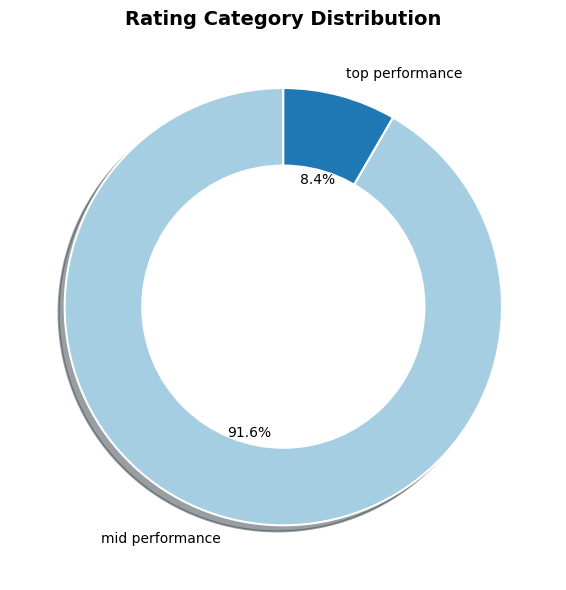

In [6]:
cat_counts = df.groupby('rating_cat').size().reset_index(name='count')
cat_counts.set_index('rating_cat', inplace=True)

colors = plt.cm.Paired(range(len(cat_counts)))

plt.figure(figsize=(8, 6))

wedges, texts, autotexts = plt.pie(
    cat_counts['count'],
    labels=cat_counts.index,
    autopct='%.1f%%',
    startangle=90,
    colors=colors,
    shadow=True,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

centre_circle = plt.Circle((0, 0), 0.65, fc='white')
plt.gca().add_artist(centre_circle)

plt.title("Rating Category Distribution", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# Exploratory Data Analysis (EDA)

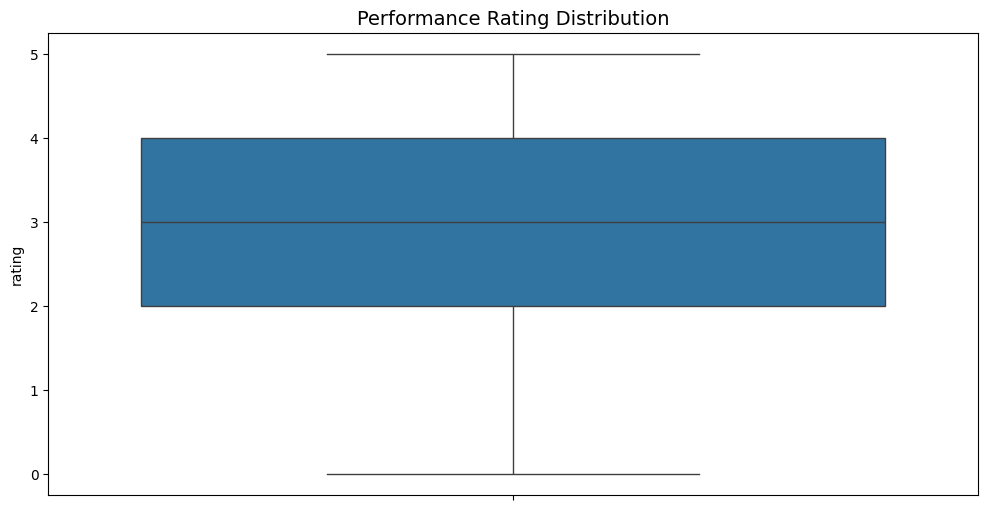

In [7]:
plt.figure(figsize=(12,6))

sns.boxplot(data = df,
            y= 'rating')

plt.title('Performance Rating Distribution', fontsize = 14)

plt.show()

## Duration Months

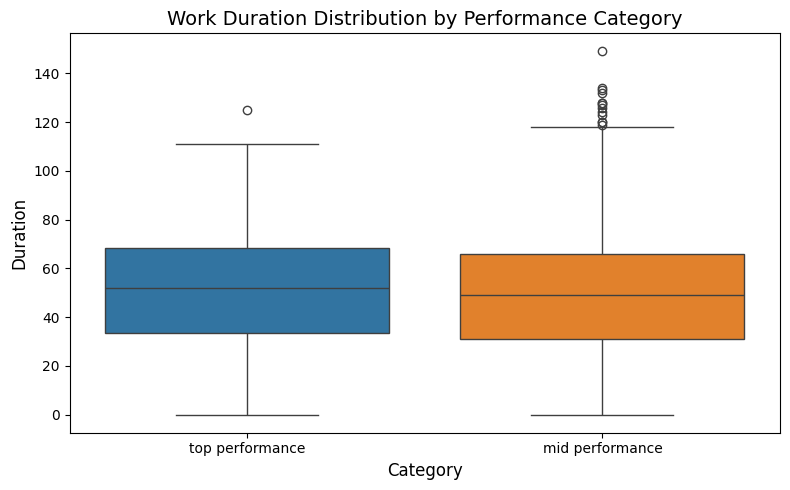

In [8]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df,
            x='rating_cat',
            y='work_duration_months',
            hue = 'rating_cat',
            palette={'top performance': '#1f77b4', 'mid performance': '#ff7f0e'})

plt.title('Work Duration Distribution by Performance Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Duration', fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
mid = df[df['rating_cat'] == 'mid performance']['work_duration_months']
top = df[df['rating_cat'] == 'top performance']['work_duration_months']

t_stat, p_value = ttest_ind(mid, top, equal_var= False)

print(f"T-statistic:, {t_stat:.2f}")
print(f"p-value:, {p_value:.2f}\n")

if p_value < 0.05:
    print("There is a significant difference between top and mid performance groups.")
else:
    print("There is no significant difference between top and mid performance groups.")

T-statistic:, -0.76
p-value:, 0.45

There is no significant difference between top and mid performance groups.


Based on the independent t-test (t = -0.76, p = 0.45), there is no statistically significant difference in average work duration between top and mid performers. This indicates that employees’ length of service does not have a measurable impact on their performance ratings.


## Education

In [10]:
df[['degree_level', 'major']] = df['education'].str.split(' - ', expand=True)


### Degree Level

In [11]:
def plot_top_proportion(df, category_col, rating_col='rating_cat', 
                        top_label='top performance', mid_label='mid performance',
                        figsize=(10,6)):

    data = (
        df.groupby([category_col, rating_col])
          .size()
          .reset_index(name='count')
    )

    prop = (
        data.pivot(index=category_col, columns=rating_col, values='count')
            .fillna(0)
            .assign(prop_top=lambda x: x[top_label] / (x[top_label] + x[mid_label]))
            .reset_index()
            .sort_values('prop_top', ascending=False)
    )

    plt.figure(figsize=figsize)
    ax = sns.barplot(data=prop, x=category_col, y='prop_top', color='skyblue')
    plt.title(f"Proportion of Top Performers by {category_col.replace('_',' ').title()}")
    plt.ylabel("Proportion of Top Performers")
    plt.xlabel(category_col.replace('_',' ').title())

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')

    plt.tight_layout()
    plt.show()

    return prop

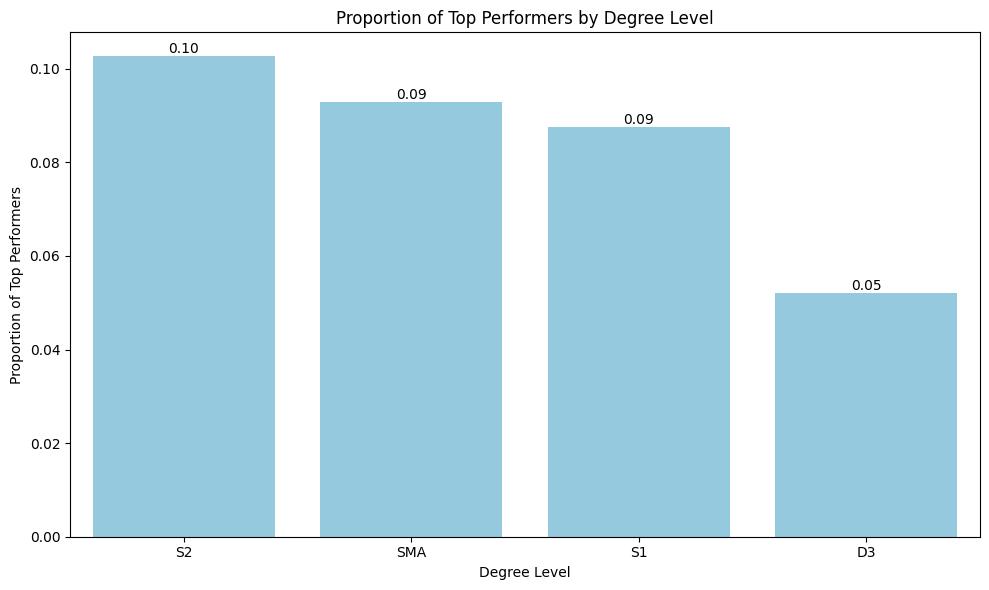

rating_cat,degree_level,mid performance,top performance,prop_top
2,S2,472,54,0.102662
3,SMA,420,43,0.092873
1,S1,459,44,0.087475
0,D3,491,27,0.052124


In [12]:
plot_top_proportion(df, 'degree_level')

In [13]:
degree_perf = pd.crosstab(df['degree_level'], df['rating_cat'])
chi2, p, dof, expected = chi2_contingency(degree_perf)
print(f"Chi-square:, {chi2:.4f}, p-value:, {p:.4f}\n")

if p < 0.05:
    print("There is a significant association between degree level and performance rating.")
else:
    print("There is no significant association between degree level and performance rating.")


Chi-square:, 9.8138, p-value:, 0.0202

There is a significant association between degree level and performance rating.


### Major Level

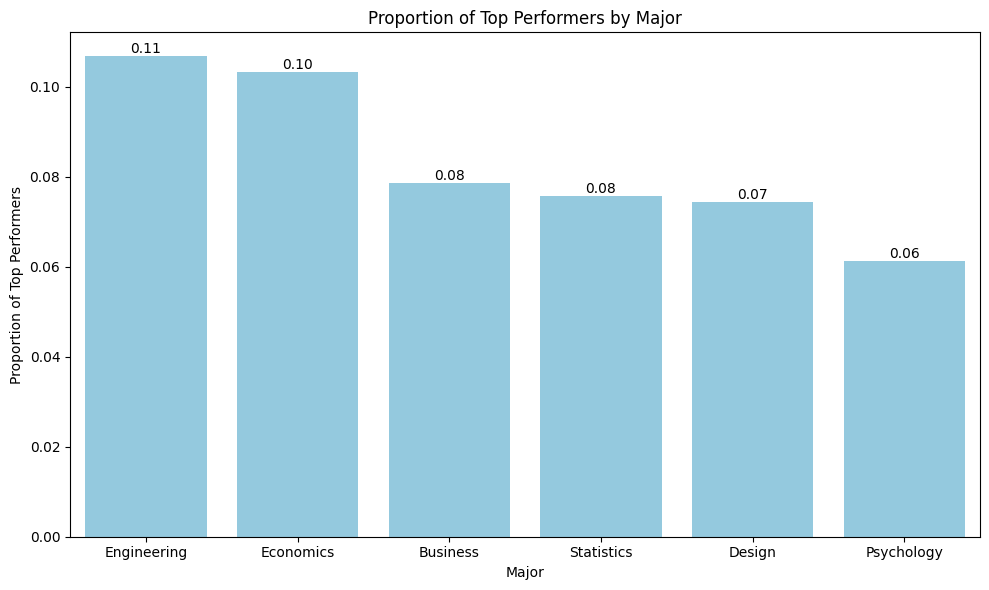

rating_cat,major,mid performance,top performance,prop_top
3,Engineering,293,35,0.106707
2,Economics,330,38,0.103261
0,Business,293,25,0.078616
5,Statistics,305,25,0.075758
1,Design,299,24,0.074303
4,Psychology,322,21,0.061224


In [14]:
plot_top_proportion(df, 'major')


In [15]:
major_perf = pd.crosstab(df['major'], df['rating_cat'])
chi2, p, dof, expected = chi2_contingency(major_perf)
print(f"Chi-square:, {chi2:.4f}, p-value:, {p:.4f}\n")

if p < 0.05:
    print("There is a significant association between major level and performance rating.")
else:
    print("There is no significant association between major level and performance rating.")


Chi-square:, 7.1181, p-value:, 0.2120

There is no significant association between major level and performance rating.


The chi-square test indicates that degree level has a statistically significant relationship with employee performance (χ² = 9.81, p = 0.02), suggesting that higher educational attainment may be associated with better performance outcomes.

However, the field of study (major) does not show a significant association with performance (χ² = 7.12, p = 0.21), implying that the type of major may not be a determining factor for performance differences in this organization.

## Cognitive

In [16]:
df[['iq', 'gtq']].describe().round(0)

,iq,gtq
count,1554.0,1678.0
mean,110.0,27.0
std,18.0,6.0
min,80.0,9.0
25%,94.0,23.0
50%,109.0,27.0
75%,125.0,32.0
max,140.0,46.0


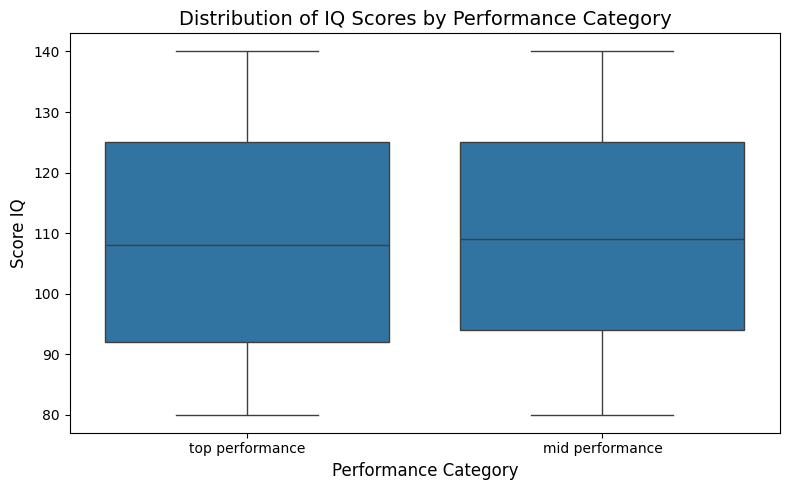

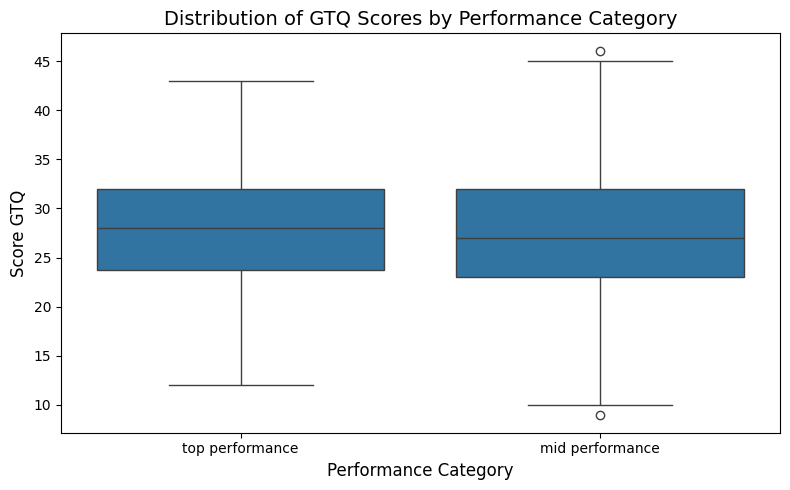

In [17]:
cog_field = ['iq', 'gtq']

for i, cog in enumerate(cog_field):
    plt.figure(figsize=(8, 5))
    
    sns.boxplot(data=df,
                x='rating_cat',
                y=cog)
    
    plt.title(f'Distribution of {cog.upper()} Scores by Performance Category', fontsize=14)
    plt.xlabel('Performance Category', fontsize=12)
    plt.ylabel(f'Score {cog.upper()}', fontsize=12)
    
    plt.tight_layout()
    plt.show()

The analysis of cognitive ability, based on the Box Plots for IQ and GTQ scores, reveals that this factor isn't a primary success driver but rather acts as a basic threshold; both Top Performers (Rating 5) and Mid Performers (Rating 1-4) exhibit largely overlapping score distributions and near-identical median scores (IQ $\approx 108-109$; GTQ $\approx 27-28.5$), meaning superior raw intelligence is not a prerequisite for achieving the highest rating.

## DISC

In [18]:
df_disc = df[['full_name', 'disc', 'rating_cat']].copy()

# DISC dimension
disc_types = ['D', 'I', 'S', 'C']

for d in disc_types:
    df_disc[d] = df_disc['disc'].apply(lambda x: 1 if d in str(x) else 0)

# rename columns
rename_map = {
    'D': 'Dominance',
    'I': 'Influence',
    'S': 'Steadiness',
    'C': 'Compliance'
}
df_disc.rename(columns=rename_map, inplace=True)

df_disc = df_disc[['full_name', 'Dominance', 'Influence', 'Steadiness', 'Compliance', 'rating_cat']]

df_disc.head()

,full_name,Dominance,Influence,Steadiness,Compliance,rating_cat
0,Dewi Fadillah Hidayat,1,0,0,1,top performance
1,Putri Wibowo,1,0,1,0,mid performance
2,Dewi Syahputra,1,1,0,0,mid performance
3,Bayu Kurniawan,1,0,0,1,mid performance
4,Fitri Anugrah Subekti,1,1,0,0,mid performance


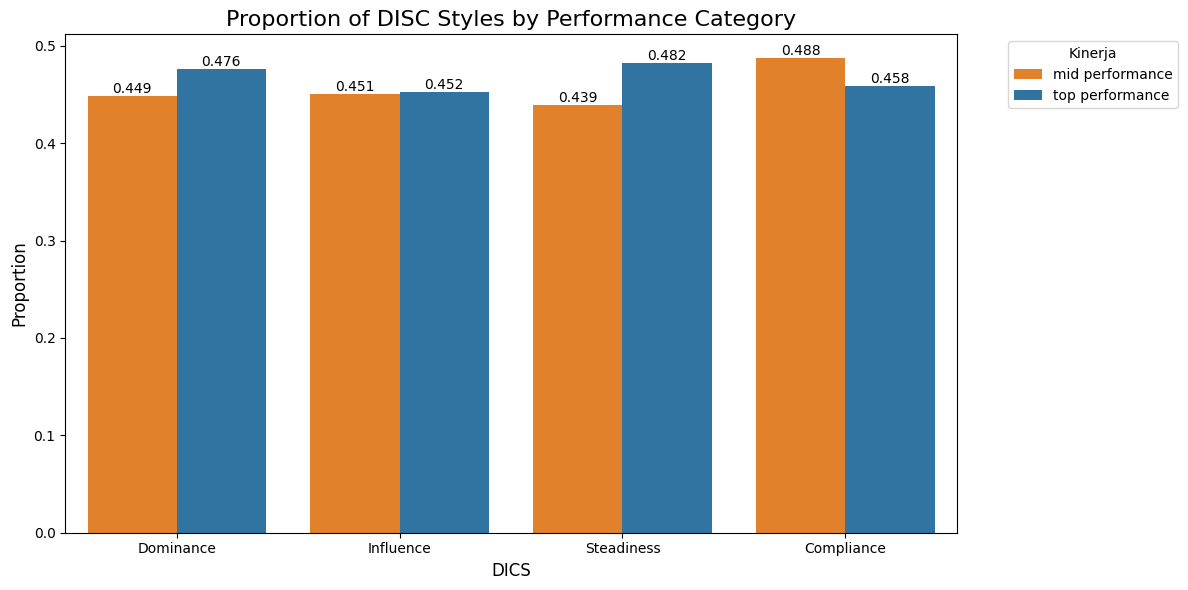

In [19]:
disc = df_disc.groupby('rating_cat')[['Dominance', 'Influence', 'Steadiness', 'Compliance']].mean().reset_index()

disc_melt = disc.melt(
    id_vars='rating_cat', 
    var_name='DISC_Style', 
    value_name='Proportion'
)

plt.figure(figsize=(12, 6))

ax = sns.barplot(data=disc_melt,
            x='DISC_Style',
            y='Proportion',
            hue='rating_cat',
            palette={'top performance': '#1f77b4', 'mid performance': '#ff7f0e'})

plt.title('Proportion of DISC Styles by Performance Category', fontsize=16)
plt.xlabel('DICS', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Kinerja', loc='upper left', bbox_to_anchor = [1.05, 1])

for container in ax.containers:
    ax.bar_label(container, label_type= 'edge', fmt = '%.3f')

plt.tight_layout()
plt.show()

In [20]:
contingency_dom = pd.crosstab(df_disc['rating_cat'], df_disc['Dominance'])
contingency_inf = pd.crosstab(df_disc['rating_cat'], df_disc['Influence'])
contingency_ste = pd.crosstab(df_disc['rating_cat'], df_disc['Steadiness'])
contingency_com = pd.crosstab(df_disc['rating_cat'], df_disc['Compliance'])

for name, table in {
    'Dominance': contingency_dom,
    'Influence': contingency_inf,
    'Steadiness': contingency_ste,
    'Compliance': contingency_com
}.items():
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"{name}: p-value = {p:.4f}")

    if p > 0.05:
        print(f"{name} does not have a statistically significant relationship with performance category.\n")
    else:
        print(f"{name} has a statistically significant relationship with performance category.\n")


Dominance: p-value = 0.5500
Dominance does not have a statistically significant relationship with performance category.

Influence: p-value = 1.0000
Influence does not have a statistically significant relationship with performance category.

Steadiness: p-value = 0.3214
Steadiness does not have a statistically significant relationship with performance category.

Compliance: p-value = 0.5197
Compliance does not have a statistically significant relationship with performance category.



## Competencies

In [21]:
def safely_load_json(data):
    if pd.isna(data):
        return []
    if isinstance(data, str):
        for loader in (json.loads, ast.literal_eval):
            try:
                return loader(data.replace("'", '"'))
            except Exception:
                continue
        return []
    if isinstance(data, (list, dict)):
        return data
    return []

def analyze_competency_pillars(df):
    records = []
    for _, row in df.iterrows():
        for item in safely_load_json(row.get('competencies')):
            pillar, score = item.get('pillar'), item.get('score')
            if pillar and pd.notna(score):
                records.append({
                    'pillar': pillar,
                    'score': float(score),
                    'rating_cat': row['rating_cat']
                })

    df_long = pd.DataFrame(records)
    if df_long.empty:
        return pd.DataFrame()

    results = []
    for pillar, group in df_long.groupby('pillar'):
        top = group.loc[group['rating_cat'] == 'top performance', 'score']
        mid = group.loc[group['rating_cat'] == 'mid performance', 'score']

        if len(top) > 1 and len(mid) > 1:
            t_stat, p_val = ttest_ind(top, mid, equal_var=False, nan_policy='omit')
            results.append({
                'Pillar': pillar,
                'Top_Mean': top.mean(),
                'Mid_Mean': mid.mean(),
                'Difference': top.mean() - mid.mean(),
                'P_Value': p_val
            })

    df_res = pd.DataFrame(results)
    if df_res.empty:
        return pd.DataFrame()

    df_res['Significance'] = np.where(df_res['P_Value'] < 0.05, 'SIGNIFICANT', 'NOT SIGNIFICANT')
    return df_res.sort_values(by=['Difference', 'P_Value'], ascending=[False, True]).reset_index(drop=True)


In [22]:
df_pillar_analysis = analyze_competency_pillars(df)
df_pillar_analysis.head()

,Pillar,Top_Mean,Mid_Mean,Difference,P_Value,Significance
0,Quality Delivery Discipline,4.691824,2.932102,1.759721,2.065227e-90,SIGNIFICANT
1,Social Empathy & Awareness,4.636943,2.925969,1.710973,9.896742e-75,SIGNIFICANT
2,Commercial Savvy & Impact,4.625000,2.927164,1.697836,4.299254e-78,SIGNIFICANT
3,Growth Drive & Resilience,4.550336,2.906158,1.644177,2.080259e-65,SIGNIFICANT
4,Value Creation for Users,4.587097,2.944048,1.643049,1.119682e-65,SIGNIFICANT


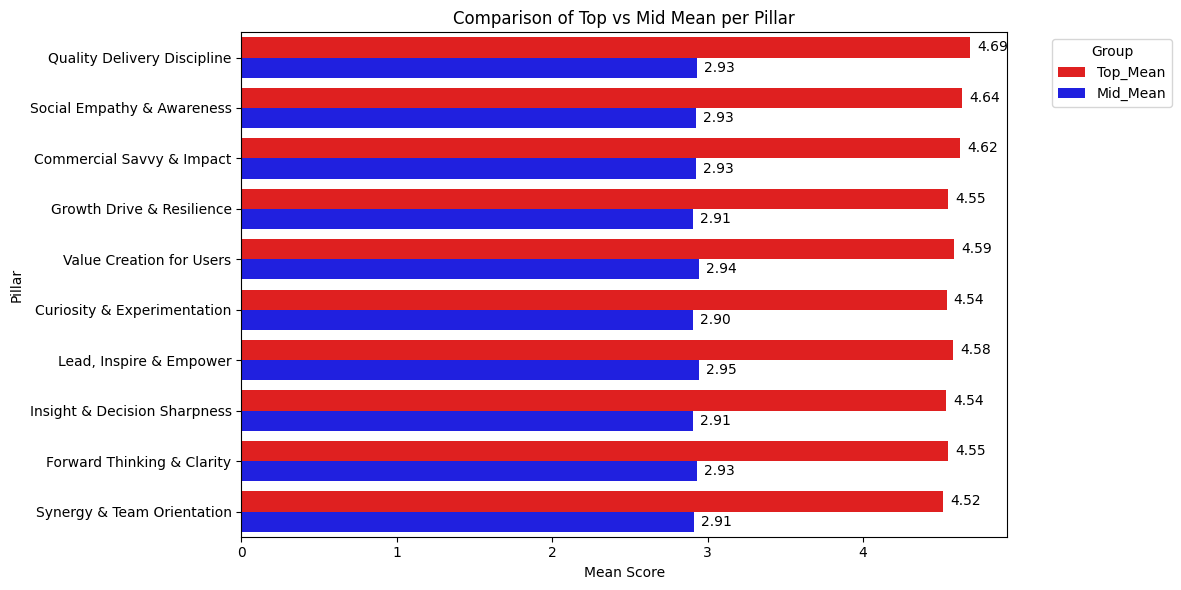

In [23]:
df_melted = df_pillar_analysis.melt(
    id_vars=['Pillar'], 
    value_vars=['Top_Mean', 'Mid_Mean'],
    var_name='Group', 
    value_name='Mean'
)

# Plot grouped bar
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_melted, 
    y='Pillar', 
    x='Mean', 
    hue='Group', 
    palette=['red', 'blue']
)

plt.title('Comparison of Top vs Mid Mean per Pillar')
plt.xlabel('Mean Score')
plt.ylabel('Pillar')
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, label_type= 'edge', fmt= '%.2f', padding = 5)
plt.tight_layout()
plt.show()


The analysis shows that competencies are key differentiators between top and mid performers. Every pillar demonstrates a notable and statistically significant gap in average scores, indicating that higher proficiency in practical skills strongly contributes to superior performance outcomes. The largest and most impactful differences appear in areas requiring execution discipline and social-business intelligence, including **Quality Delivery Discipline** (1.76 points higher), **Social Empathy & Awareness** (1.71 points higher), and **Commercial Savvy & Impact** (1.70 points). This suggests that top performers consistently excel by applying their knowledge, discipline, and judgment effectively in real-world scenarios, making mastery of these specific skills the core requirement for high performance.

In [24]:
def extract_competencies(comp_data):
    """Extract competency scores by pillar"""
    if pd.isna(comp_data) or comp_data == '[]':
        return {}
    
    try:
        comp_list = eval(comp_data) if isinstance(comp_data, str) else comp_data
        comp_dict = {}
        for item in comp_list:
            pillar = item.get('pillar', '')
            score = item.get('score', None)
            if pillar and score is not None:
                # Clean pillar name for column
                clean_name = pillar.replace(' ', '_').replace('&', 'and').replace(',', '')
                comp_dict[clean_name] = score
        return comp_dict
    except:
        return {}

# Apply extraction
comp_expanded = df['competencies'].apply(extract_competencies)
comp_df = pd.DataFrame(comp_expanded.tolist())

# Merge back
df = pd.concat([df, comp_df], axis=1)

In [25]:
# Rename competency columns
competency_mapping = {
    'Growth_Drive_and_Resilience': 'Growth_Drive',
    'Social_Empathy_and_Awareness': 'Social_Empathy',
    'Commercial_Savvy_and_Impact': 'Commercial_Savvy',
    'Value_Creation_for_Users': 'Value_Creation',
    'Quality_Delivery_Discipline': 'Quality_Delivery',
    'Curiosity_and_Experimentation': 'Curiosity',
    'Lead_Inspire_and_Empower': 'Lead_Inspire',
    'Insight_and_Decision_Sharpness': 'Insight_Decision',
    'Forward_Thinking_and_Clarity': 'Forward_Thinking',
    'Synergy_and_Team_Orientation': 'Team_Orientation'
}

df = df.rename(columns=competency_mapping)

df.head()

,employee_id,full_name,work_duration_months,education,grade,disc,disc_word,mbti,iq,gtq,papi_data,employee_strengths,competencies,rating,rating_cat,degree_level,major,Growth_Drive,Curiosity,Insight_Decision,Quality_Delivery,Team_Orientation,Social_Empathy,Value_Creation,Forward_Thinking,Commercial_Savvy,Lead_Inspire
0,DUP1942,Dewi Fadillah Hidayat,79,S1 - Design,IV,CD,Conscientious-Dominant,ISFP,NaN,NaN,"[{'scale_code': 'Papi_N', 'score': None}, {'sc...","[{'strengh': 'Learner', 'rank': 1}, {'strengh'...","[{'pillar': 'Growth Drive & Resilience', 'scor...",5.0,top performance,S1,Design,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN
1,DUP2096,Putri Wibowo,49,S2 - Engineering,III,SD,Steadiness-Dominant,ISFJ,NaN,NaN,"[{'scale_code': 'Papi_N', 'score': 1}, {'scale...","[{'strengh': 'Command', 'rank': 1}, {'strengh'...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0,mid performance,S2,Engineering,3.0,3.0,4.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0
2,DUP2722,Dewi Syahputra,33,S1 - Design,IV,DI,Dominant-Influencer,ISTJ,124.0,18.0,"[{'scale_code': 'Papi_N', 'score': 8}, {'scale...","[{'strengh': 'Individualization', 'rank': 1}, ...","[{'pillar': 'Growth Drive & Resilience', 'scor...",4.0,mid performance,S1,Design,5.0,3.0,4.0,3.0,NaN,4.0,5.0,5.0,5.0,5.0
3,DUP3015,Bayu Kurniawan,79,SMA - Business,III,CD,Conscientious-Dominant,ESFP,87.0,22.0,"[{'scale_code': 'Papi_N', 'score': 5}, {'scale...","[{'strengh': 'Responsibility', 'rank': 1}, {'s...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0,mid performance,SMA,Business,3.0,2.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
4,DUP3452,Fitri Anugrah Subekti,50,D3 - Psychology,V,ID,Influencer-Dominant,ESFJ,90.0,38.0,"[{'scale_code': 'Papi_N', 'score': None}, {'sc...","[{'strengh': 'Developer', 'rank': 1}, {'streng...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0,mid performance,D3,Psychology,3.0,3.0,3.0,4.0,3.0,4.0,4.0,2.0,2.0,3.0


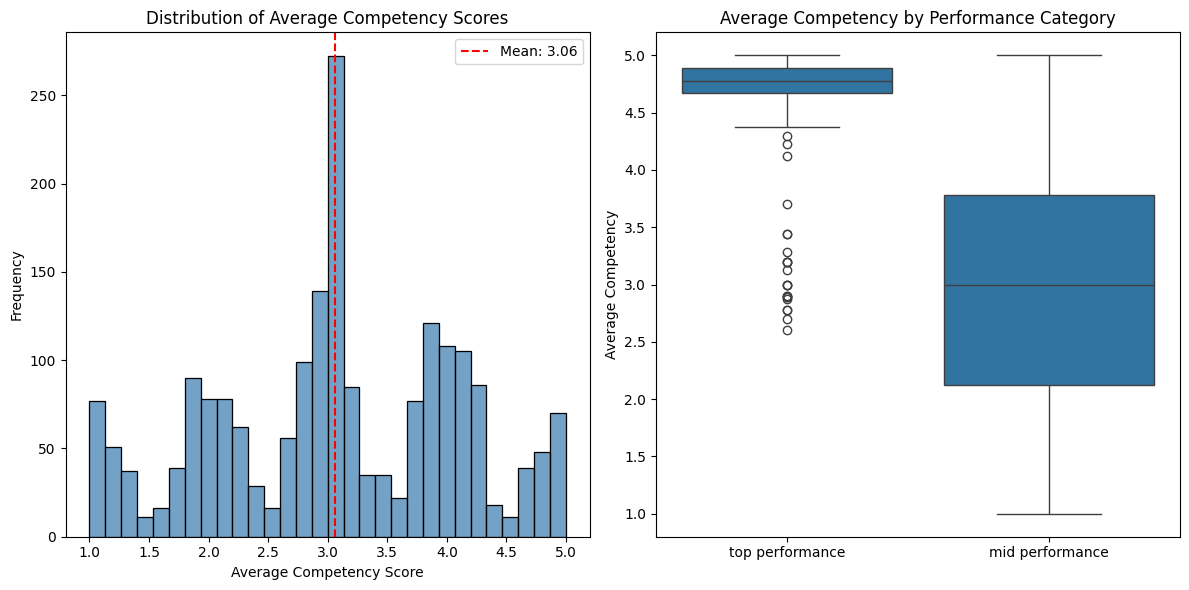

<Figure size 640x480 with 0 Axes>

In [26]:
competency_cols = [
    'Quality_Delivery', 'Social_Empathy', 'Commercial_Savvy',
    'Growth_Drive', 'Value_Creation', 'Curiosity',
    'Lead_Inspire', 'Insight_Decision', 'Forward_Thinking',
    'Team_Orientation'
]

# Calculate average (handle NaN)
df['avg_competency'] = df[competency_cols].mean(axis = 1, skipna=True)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)

sns.histplot(data = df,
             x = 'avg_competency',
             bins = 30,
             color = 'steelblue',
             edgecolor = 'black')

plt.title('Distribution of Average Competency Scores')
plt.xlabel('Average Competency Score')
plt.ylabel('Frequency')
plt.axvline(df['avg_competency'].mean(), color='red', linestyle='--', label=f'Mean: {df["avg_competency"].mean():.2f}')
plt.legend()

plt.subplot(1,2,2)

sns.boxplot(data = df,
            y = 'avg_competency',
            x = 'rating_cat')

plt.title('Average Competency by Performance Category')
plt.xlabel(None)
plt.ylabel('Average Competency')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

## PAPI

In [27]:
df['papi_data'] = df['papi_data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df_papi = df.explode('papi_data', ignore_index=True)

df_papi = pd.concat(
    [df_papi[['employee_id', 'full_name', 'rating', 'rating_cat']], 
     df_papi['papi_data'].apply(pd.Series)], 
    axis=1
)

df_papi = df_papi.pivot_table(
    index=['employee_id', 'full_name', 'rating', 'rating_cat'],
    columns='scale_code',
    values='score',
    aggfunc='first'
).reset_index()

df_papi.columns.name = None

df_papi.head()

,employee_id,full_name,rating,rating_cat,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,Papi_I,Papi_K,Papi_L,Papi_N,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z
0,DUP1942,Dewi Fadillah Hidayat,5.0,top performance,6.0,NaN,1.0,4.0,3.0,5.0,4.0,1.0,3.0,6.0,NaN,3.0,5.0,7.0,9.0,9.0,1.0,8.0,3.0,NaN
1,DUP2096,Putri Wibowo,3.0,mid performance,1.0,6.0,9.0,3.0,4.0,1.0,2.0,6.0,9.0,3.0,1.0,4.0,4.0,6.0,8.0,2.0,6.0,3.0,8.0,2.0
2,DUP2722,Dewi Syahputra,4.0,mid performance,2.0,NaN,6.0,4.0,1.0,4.0,9.0,9.0,1.0,3.0,8.0,2.0,NaN,6.0,1.0,7.0,3.0,6.0,3.0,3.0
3,DUP3015,Bayu Kurniawan,3.0,mid performance,5.0,4.0,3.0,4.0,9.0,2.0,8.0,9.0,1.0,7.0,5.0,1.0,8.0,7.0,3.0,NaN,NaN,3.0,5.0,3.0
4,DUP3452,Fitri Anugrah Subekti,3.0,mid performance,7.0,9.0,1.0,9.0,7.0,3.0,NaN,2.0,1.0,4.0,NaN,NaN,4.0,2.0,9.0,NaN,9.0,1.0,6.0,4.0


In [28]:
papi_cols = [col for col in df_papi.columns if col.startswith('Papi_')]

df_papi[papi_cols] = df_papi[papi_cols].fillna(df_papi[papi_cols].median())

df_papi.head()

,employee_id,full_name,rating,rating_cat,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,Papi_I,Papi_K,Papi_L,Papi_N,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z
0,DUP1942,Dewi Fadillah Hidayat,5.0,top performance,6.0,5.0,1.0,4.0,3.0,5.0,4.0,1.0,3.0,6.0,5.0,3.0,5.0,7.0,9.0,9.0,1.0,8.0,3.0,5.0
1,DUP2096,Putri Wibowo,3.0,mid performance,1.0,6.0,9.0,3.0,4.0,1.0,2.0,6.0,9.0,3.0,1.0,4.0,4.0,6.0,8.0,2.0,6.0,3.0,8.0,2.0
2,DUP2722,Dewi Syahputra,4.0,mid performance,2.0,5.0,6.0,4.0,1.0,4.0,9.0,9.0,1.0,3.0,8.0,2.0,5.0,6.0,1.0,7.0,3.0,6.0,3.0,3.0
3,DUP3015,Bayu Kurniawan,3.0,mid performance,5.0,4.0,3.0,4.0,9.0,2.0,8.0,9.0,1.0,7.0,5.0,1.0,8.0,7.0,3.0,5.0,5.0,3.0,5.0,3.0
4,DUP3452,Fitri Anugrah Subekti,3.0,mid performance,7.0,9.0,1.0,9.0,7.0,3.0,5.0,2.0,1.0,4.0,5.0,5.0,4.0,2.0,9.0,5.0,9.0,1.0,6.0,4.0


In [29]:
mean_papi = df_papi.groupby('rating_cat')[papi_cols].mean().reset_index()

mean_papi

,rating_cat,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,Papi_I,Papi_K,Papi_L,Papi_N,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z
0,mid performance,5.018473,4.915640,4.855911,4.953818,5.044951,5.036946,4.975369,5.043719,5.048030,5.103448,5.082512,4.905788,4.988916,5.020320,5.012315,5.003695,4.883621,4.937192,5.035714,4.959360
1,top performance,4.833333,4.928571,4.726190,4.851190,5.136905,5.083333,4.672619,5.113095,5.017857,5.005952,5.154762,4.815476,5.321429,4.994048,4.702381,4.726190,4.958333,5.142857,4.928571,5.041667


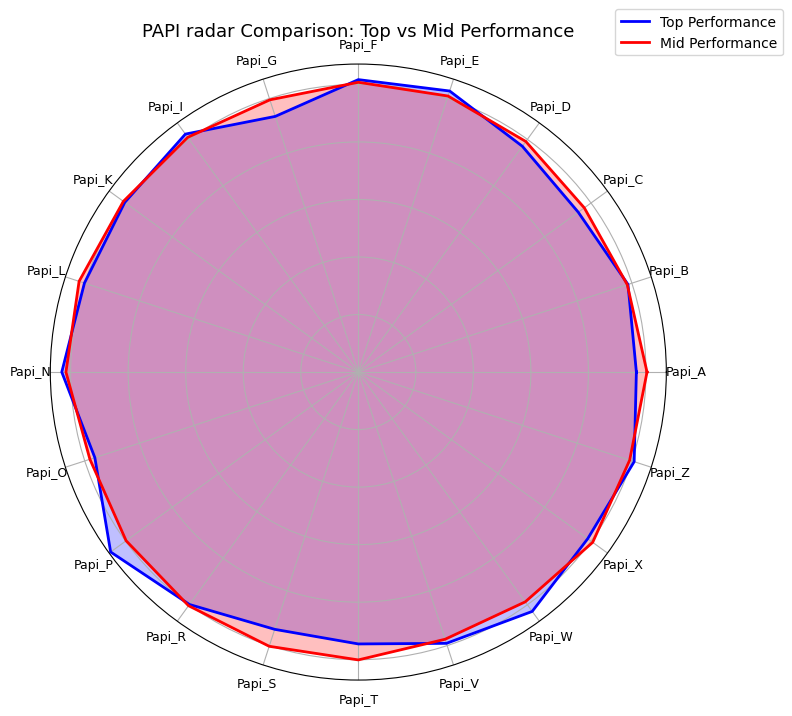

In [30]:
values_top = mean_papi.loc[mean_papi['rating_cat'] == 'top performance', papi_cols].values.flatten()
values_mid = mean_papi.loc[mean_papi['rating_cat'] == 'mid performance', papi_cols].values.flatten()

values_top = np.append(values_top, values_top[0])
values_mid = np.append(values_mid, values_mid[0])
angles = np.linspace(0, 2 * np.pi, len(papi_cols), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Line for top and mid
ax.plot(angles, values_top, linewidth=2, linestyle='solid', label='Top Performance', color='blue')
ax.fill(angles, values_top, alpha=0.25, color='blue')

ax.plot(angles, values_mid, linewidth=2, linestyle='solid', label='Mid Performance', color='red')
ax.fill(angles, values_mid, alpha=0.25, color='red')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(papi_cols, fontsize=9)
ax.set_yticklabels([])
plt.title('PAPI radar Comparison: Top vs Mid Performance', size=13, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.show()

In [31]:
target_column = 'rating_cat' 

binary_target = df_papi[target_column].map({
    'top performance': 1,
    'mid performance': 0
}).astype(float)

# 2. Siapkan DataFrame untuk korelasi
df_for_corr = df_papi[papi_cols].copy()
df_for_corr['binary_target'] = binary_target

# 3. Hitung korelasi Point-Biserial
correlation_results = df_for_corr.corr(method='pearson')['binary_target'].sort_values(ascending=False)

# 4. Hapus korelasi dirinya sendiri dan tampilkan hasilnya
papi_correlations = correlation_results.drop('binary_target')

print("Top 10 PAPI Scales Most Correlated with High Performance")
print(papi_correlations.head(10).to_string())

print("\nBottom 5 PAPI Scales That Least Correlation with High Performance")
print(papi_correlations.tail(5).to_string())

Top 10 PAPI Scales Most Correlated with High Performance
Papi_P    0.038516
Papi_W    0.023938
Papi_E    0.010628
Papi_Z    0.009698
Papi_V    0.008801
Papi_N    0.008592
Papi_I    0.008065
Papi_F    0.005475
Papi_B    0.001498
Papi_R   -0.003100

Bottom 5 PAPI Scales That Least Correlation with High Performance
Papi_C   -0.015432
Papi_A   -0.022095
Papi_T   -0.032667
Papi_G   -0.035556
Papi_S   -0.036211


The analysis of PAPI scores revealed that **behavioral preferences are not a significant driver of high performance**, as the visual comparison shows the profiles of Top Performers (Rating 5) and Mid Performers (Rating 1-4) are **virtually identical across all 20 scales**. This uniformity confirms that there is no unique behavioral blueprint or innate personality trait that statistically separates the most successful employees from the average. Consequently, the **Behavioral TGV must be given a minimal weight** (recommended $\mathbf{10\%}$), acting only as a tie-breaker or low-impact filter in the final Success Formula, while reinforcing that success hinges on acquired skills rather than inherent personality.

In [32]:
df_papi = df_papi.drop(columns = ['rating', 'rating_cat', 'full_name'])# 

df = pd.merge(df, df_papi, on = 'employee_id', how = 'left')
df = df.drop(columns = 'papi_data')

df.head()

,employee_id,full_name,work_duration_months,education,grade,disc,disc_word,mbti,iq,gtq,employee_strengths,competencies,rating,rating_cat,degree_level,major,Growth_Drive,Curiosity,Insight_Decision,Quality_Delivery,Team_Orientation,Social_Empathy,Value_Creation,Forward_Thinking,Commercial_Savvy,Lead_Inspire,avg_competency,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,Papi_I,Papi_K,Papi_L,Papi_N,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z
0,DUP1942,Dewi Fadillah Hidayat,79,S1 - Design,IV,CD,Conscientious-Dominant,ISFP,NaN,NaN,"[{'strengh': 'Learner', 'rank': 1}, {'strengh'...","[{'pillar': 'Growth Drive & Resilience', 'scor...",5.0,top performance,S1,Design,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,4.888889,6.0,5.0,1.0,4.0,3.0,5.0,4.0,1.0,3.0,6.0,5.0,3.0,5.0,7.0,9.0,9.0,1.0,8.0,3.0,5.0
1,DUP2096,Putri Wibowo,49,S2 - Engineering,III,SD,Steadiness-Dominant,ISFJ,NaN,NaN,"[{'strengh': 'Command', 'rank': 1}, {'strengh'...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0,mid performance,S2,Engineering,3.0,3.0,4.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,2.900000,1.0,6.0,9.0,3.0,4.0,1.0,2.0,6.0,9.0,3.0,1.0,4.0,4.0,6.0,8.0,2.0,6.0,3.0,8.0,2.0
2,DUP2722,Dewi Syahputra,33,S1 - Design,IV,DI,Dominant-Influencer,ISTJ,124.0,18.0,"[{'strengh': 'Individualization', 'rank': 1}, ...","[{'pillar': 'Growth Drive & Resilience', 'scor...",4.0,mid performance,S1,Design,5.0,3.0,4.0,3.0,NaN,4.0,5.0,5.0,5.0,5.0,4.333333,2.0,5.0,6.0,4.0,1.0,4.0,9.0,9.0,1.0,3.0,8.0,2.0,5.0,6.0,1.0,7.0,3.0,6.0,3.0,3.0
3,DUP3015,Bayu Kurniawan,79,SMA - Business,III,CD,Conscientious-Dominant,ESFP,87.0,22.0,"[{'strengh': 'Responsibility', 'rank': 1}, {'s...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0,mid performance,SMA,Business,3.0,2.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.100000,5.0,4.0,3.0,4.0,9.0,2.0,8.0,9.0,1.0,7.0,5.0,1.0,8.0,7.0,3.0,5.0,5.0,3.0,5.0,3.0
4,DUP3452,Fitri Anugrah Subekti,50,D3 - Psychology,V,ID,Influencer-Dominant,ESFJ,90.0,38.0,"[{'strengh': 'Developer', 'rank': 1}, {'streng...","[{'pillar': 'Growth Drive & Resilience', 'scor...",3.0,mid performance,D3,Psychology,3.0,3.0,3.0,4.0,3.0,4.0,4.0,2.0,2.0,3.0,3.100000,7.0,9.0,1.0,9.0,7.0,3.0,5.0,2.0,1.0,4.0,5.0,5.0,4.0,2.0,9.0,5.0,9.0,1.0,6.0,4.0


## Strengths

In [33]:
df[['full_name', 'employee_strengths']].head()

,full_name,employee_strengths
0,Dewi Fadillah Hidayat,"[{'strengh': 'Learner', 'rank': 1}, {'strengh'..."
1,Putri Wibowo,"[{'strengh': 'Command', 'rank': 1}, {'strengh'..."
2,Dewi Syahputra,"[{'strengh': 'Individualization', 'rank': 1}, ..."
3,Bayu Kurniawan,"[{'strengh': 'Responsibility', 'rank': 1}, {'s..."
4,Fitri Anugrah Subekti,"[{'strengh': 'Developer', 'rank': 1}, {'streng..."


In [34]:
def safely_load_json(data):
    if data is None or (isinstance(data, float) and np.isnan(data)):
        return []
    if isinstance(data, (list, dict)):
        return data
    if isinstance(data, str):
        try:
            return json.loads(data.replace("'", '"'))
        except:
            try:
                return ast.literal_eval(data)
            except:
                return []
    return []

def get_strength_counts(df):
    all_strengths = []
    for entry in df['employee_strengths'].apply(safely_load_json):
        for item in entry:
            theme = item.get('strengh')
            if theme:
                all_strengths.append(theme.strip())
    return Counter(all_strengths)

top_strengths = get_strength_counts(df[df['rating_cat'] == 'top performance'])
mid_strengths = get_strength_counts(df[df['rating_cat'] == 'mid performance'])

df_comp = (
    pd.DataFrame({'Top_Count': top_strengths})
    .join(pd.DataFrame({'Mid_Count': mid_strengths}), how='outer')
    .fillna(0)
    .reset_index()
    .rename(columns={'index': 'Strength'})
)

df_comp['Total_Count'] = df_comp['Top_Count'] + df_comp['Mid_Count']
df_comp['Top_Proportion'] = df_comp['Top_Count'] / df_comp['Total_Count']

df_top10 = df_comp.sort_values('Top_Proportion', ascending=False).head(10)
df_top10[['Strength', 'Top_Count', 'Mid_Count', 'Top_Proportion']]


,Strength,Top_Count,Mid_Count,Top_Proportion
17,Futuristic,78,696,0.100775
23,Intellection,77,697,0.099483
13,Developer,66,661,0.090784
11,Context,70,704,0.090439
18,Harmony,65,657,0.090028
3,Analytical,67,685,0.089096
20,Includer,65,676,0.087719
9,Connectedness,65,678,0.087483
7,Communication,67,699,0.087467
27,Relator,66,698,0.086387


In [35]:
contingency = df_comp[['Top_Count', 'Mid_Count']].astype(int)
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-square:, {chi2:.4f}, p-value:, {p:.4f}\n")

if p < 0.05:
    print("There is significant difference in strengths distribution between top and mid performance groups.")
else:
    print("There is no significant difference in strengths distribution between top and mid performance groups.")



Chi-square:, 17.9382, p-value:, 0.9847

There is no significant difference in strengths distribution between top and mid performance groups.


# Validation Success Formula

## Layer 1: Foundation Check

In [36]:
critical = ['Quality_Delivery', 'Commercial_Savvy', 'Social_Empathy']

def check_foundation(row):
    for comp in critical:
        if row.get(comp, 0) < 3:
            return False, comp
    return True, None

def safe_get(row, col, default=0):
    return row.get(col, default) or default

In [37]:
competency_mapping = {
    'Growth_Drive_and_Resilience': 'Growth_Drive',
    'Social_Empathy_and_Awareness': 'Social_Empathy',
    'Commercial_Savvy_and_Impact': 'Commercial_Savvy',
    'Value_Creation_for_Users': 'Value_Creation',
    'Quality_Delivery_Discipline': 'Quality_Delivery',
    'Curiosity_and_Experimentation': 'Curiosity',
    'Lead_Inspire_and_Empower': 'Lead_Inspire',
    'Insight_and_Decision_Sharpness': 'Insight_Decision',
    'Forward_Thinking_and_Clarity': 'Forward_Thinking',
    'Synergy_and_Team_Orientation': 'Team_Orientation'
}

## Layer 2: Competency Clusters

In [38]:
def calc_execution_cluster(row):
    """Execution Excellence = Quality + Planning + Team"""
    quality = safe_get(row, 'Quality_Delivery', 0)
    forward = safe_get(row, 'Forward_Thinking', 0)
    team = safe_get(row, 'Team_Orientation', 0)
    
    if quality == 0:
        return 0
    
    base = (quality + forward + team) / 3
    
    # Synergy rules
    if quality >= 4.5 and forward >= 4.0:
        return base * 1.2  # High synergy bonus
    elif quality >= 4.0 and forward >= 4.0 and team >= 4.0:
        return base * 1.1  # Balanced competence bonus
    else:
        return base * 1.0  # No synergy

def calc_strategic_cluster(row):
    """Strategic Impact = Commercial + Insight + Value"""
    commercial = safe_get(row, 'Commercial_Savvy', 0)
    insight = safe_get(row, 'Insight_Decision', 0)
    value = safe_get(row, 'Value_Creation', 0)
    
    if commercial == 0:
        return 0
    
    base = (commercial + insight + value) / 3
    
    # Synergy rules
    if commercial >= 4.5 and insight >= 4.3 and value >= 4.5:
        return base * 1.25  # Strategic leader profile
    elif commercial >= 4.0 and (insight >= 4.0 or value >= 4.0):
        return base * 1.1   # Emerging strategic thinker
    else:
        return base * 1.0   # Operational focus

def calc_growth_cluster(row):
    """Growth & Innovation = Drive + Curiosity"""
    growth = safe_get(row, 'Growth_Drive', 0)
    curiosity = safe_get(row, 'Curiosity', 0)
    
    if growth == 0:
        return 0
    
    base = (growth + curiosity) / 2
    
    # Synergy rules
    if growth >= 4.5 and curiosity >= 4.5:
        return base * 1.3  # Innovation multiplier
    else:
        return base * 1.0

def calc_leadership_cluster(row):
    """People Leadership = Lead + Empathy"""
    leadership = safe_get(row, 'Lead_Inspire', 0)
    empathy = safe_get(row, 'Social_Empathy', 0)
    
    if leadership == 0:
        return 0
    
    base = (leadership + empathy) / 2
    
    # Synergy rules
    if leadership >= 4.5 and empathy >= 4.5:
        return base * 1.2  # Strong people leader
    else:
        return base * 1.0

## layer 3: Contextual Modifiers

In [39]:
def calc_education_modifier(row):
    """Education amplifies competency when aligned"""
    education = row.get('degree_level', '')
    avg_comp = safe_get(row, 'avg_competency', 0)
    
    # Rule-based education impact
    if education == 'S2' and avg_comp >= 4.5:
        return 1.15  # S2 fully leveraged
    elif education == 'SMA' and avg_comp >= 4.5:
        return 1.10  # Overperformer bonus
    elif education == 'S2' and avg_comp < 4.0:
        return 1.02  # Education underutilized
    elif education in ['S1', 'SMA']:
        return 1.05  # Standard alignment
    elif education == 'D3':
        return 1.03
    else:
        return 1.0

def calc_papi_modifier(row):
    """PAPI personality-skill alignment bonus"""
    papi_p = safe_get(row, 'Papi_P', 5)  # Need to finish tasks
    papi_w = safe_get(row, 'Papi_W', 5)  # Need to control others
    quality = safe_get(row, 'Quality_Delivery', 0)
    leadership = safe_get(row, 'Lead_Inspire', 0)
    
    # Personality-skill alignment rules
    if papi_p >= 7 and quality >= 4.5:
        return 1.08  # Task drive matches quality execution
    elif papi_w >= 6 and leadership >= 4.5:
        return 1.06  # Control orientation supports leadership
    else:
        return 1.0

## Main Calculation Function

In [40]:
def calculate_success_score(row):

    if pd.isna(row.get('avg_competency')) or row['avg_competency'] == 0:
        return {
            'success_score': np.nan,
            'base_score': np.nan,
            'education_modifier': np.nan,
            'papi_modifier': np.nan,
            'can_reach_rating_5': False,
            'blocker': 'No competency data',
            'profile': 'Insufficient Data',
            'prediction': 'Cannot assess',
            'execution_score': np.nan,
            'strategic_score': np.nan,
            'growth_score': np.nan,
            'leadership_score': np.nan
        }
    
    # Layer 1: Foundation check (Gate-keeping)
    passed, failed_comp = check_foundation(row)
    if not passed:
        return {
            'success_score': 3.5,
            'base_score': 3.5,
            'education_modifier': 1.0,
            'papi_modifier': 1.0,
            'can_reach_rating_5': False,
            'blocker': failed_comp,
            'profile': 'Foundation Gap',
            'prediction': 'Cannot reach Rating 5',
            'execution_score': np.nan,
            'strategic_score': np.nan,
            'growth_score': np.nan,
            'leadership_score': np.nan
        }
    
    # Layer 2: Calculate competency clusters with synergy
    execution = calc_execution_cluster(row)
    strategic = calc_strategic_cluster(row)
    growth = calc_growth_cluster(row)
    leadership = calc_leadership_cluster(row)
    
    # Weighted base score
    base_score = (
        execution * 0.35 +
        strategic * 0.30 +
        growth * 0.25 +
        leadership * 0.10
    )
    
    # Layer 3: Apply contextual modifiers
    education_mod = calc_education_modifier(row)
    papi_mod = calc_papi_modifier(row)
    
    # Final calculation with modifiers
    final = base_score * education_mod * papi_mod
    final = min(final, 5.0)  # Cap at 5
    
    # Categorize result
    if final >= 4.7:
        profile = 'Top Performer Profile'
        prediction = 'High likelihood Rating 5'
    elif final >= 4.0:
        profile = 'Emerging High Performer'
        prediction = 'Potential for Rating 5'
    else:
        profile = 'Developing Performer'
        prediction = 'Needs development'
    
    return {
        'success_score': round(final, 2),
        'base_score': round(base_score, 2),
        'education_modifier': round(education_mod, 2),
        'papi_modifier': round(papi_mod, 2),
        'can_reach_rating_5': True,
        'blocker': None,
        'profile': profile,
        'prediction': prediction,
        'execution_score': round(execution, 2),
        'strategic_score': round(strategic, 2),
        'growth_score': round(growth, 2),
        'leadership_score': round(leadership, 2)
    }

## Calculating success scores for all employees

In [41]:
# Apply to each row
results = df.apply(calculate_success_score, axis=1)

# Convert to DataFrame
results_df = pd.DataFrame(results.tolist())

# Merge with original
df = pd.concat([df, results_df], axis=1)

print(f"Success scores calculated for {len(df)} employees")

# Display sample results
sample_cols = ['full_name', 'rating', 'success_score', 'profile', 'prediction']
df[sample_cols].head(10)

Success scores calculated for 2010 employees


,full_name,rating,success_score,profile,prediction
0,Dewi Fadillah Hidayat,5.0,NaN,Developing Performer,Needs development
1,Putri Wibowo,3.0,3.50,Foundation Gap,Cannot reach Rating 5
2,Dewi Syahputra,4.0,NaN,Developing Performer,Needs development
3,Bayu Kurniawan,3.0,3.25,Developing Performer,Needs development
4,Fitri Anugrah Subekti,3.0,3.50,Foundation Gap,Cannot reach Rating 5
5,Adi Ginting,2.0,3.50,Foundation Gap,Cannot reach Rating 5
6,Fajar Fauziah,3.0,NaN,Developing Performer,Needs development
7,Umar Maulana,3.0,3.27,Developing Performer,Needs development
8,Nabila Dharma Salsabila,NaN,4.51,Emerging High Performer,Potential for Rating 5
9,Ayu Kusuma Santoso,5.0,5.00,Top Performer Profile,High likelihood Rating 5


## Validation Results

In [42]:
# Filter only rows with valid scores
df_valid = df[df['success_score'].notna()].copy()

print(f"\nValid data: {len(df_valid)} employees")
print(f"\nSuccess Score Statistics:")
print(df_valid['success_score'].describe())

# Profile distribution
print("\nProfile Distribution:")
profile_dist = df_valid['profile'].value_counts()
print(profile_dist)
print("\nPercentages:")
print((profile_dist / len(df_valid) * 100).round(2))

# Create rating_cat if not exists
if 'rating_cat' not in df_valid.columns and 'rating' in df_valid.columns:
    df_valid['rating_cat'] = df_valid['rating'].apply(
        lambda x: 'top performance' if x == 5 else 'mid performance' if pd.notna(x) else 'unknown'
    )

# Success Score by Actual Rating
if 'rating_cat' in df_valid.columns:
    print("\nSuccess Score Distribution by Actual Rating Category:")
    rating_summary = df_valid.groupby('rating_cat')['success_score'].describe()
    display(rating_summary)


Valid data: 1356 employees

Success Score Statistics:
count    1356.000000
mean        3.703945
std         0.503758
min         2.460000
25%         3.500000
50%         3.500000
75%         3.500000
max         5.000000
Name: success_score, dtype: float64

Profile Distribution:
profile
Foundation Gap             902
Developing Performer       168
Emerging High Performer    162
Top Performer Profile      124
Name: count, dtype: int64

Percentages:
profile
Foundation Gap             66.52
Developing Performer       12.39
Emerging High Performer    11.95
Top Performer Profile       9.14
Name: count, dtype: float64

Success Score Distribution by Actual Rating Category:


,count,mean,std,min,25%,50%,75%,max
rating_cat,,,,,,,,
mid performance,1276.0,3.636466,0.416697,2.46,3.5,3.5,3.5,5.0
top performance,80.0,4.780250,0.551070,2.99,5.0,5.0,5.0,5.0


## Classification Performance


Classification Report:
                 precision    recall  f1-score   support

Mid Performance      0.990     0.956     0.973      1276
Top Performance      0.548     0.850     0.667        80

       accuracy                          0.950      1356
      macro avg      0.769     0.903     0.820      1356
   weighted avg      0.964     0.950     0.955      1356



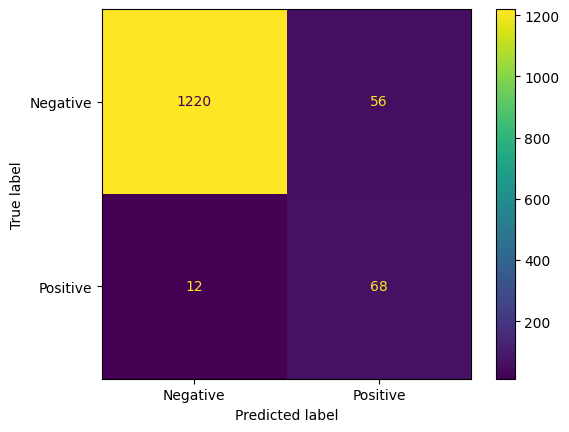

   Accuracy:  0.950
   Precision: 0.548
   Recall:    0.850
   AUC Score: 0.897


In [43]:
if 'rating' in df_valid.columns:
    df_valid['predicted_top'] = (df_valid['success_score'] >= 4.7).astype(int)
    df_valid['actual_top'] = (df_valid['rating'] == 5).astype(int)
    
    print("\nClassification Report:")
    print(classification_report(
        df_valid['actual_top'],
        df_valid['predicted_top'],
        target_names=['Mid Performance', 'Top Performance'],
        digits=3
    ))
    
    # Confusion matrix
    cm = confusion_matrix(df_valid['actual_top'], df_valid['predicted_top'])
    cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= ['Negative', 'Positive'])
    cm_disp.plot()
    plt.show()
    
    accuracy = accuracy_score(df_valid['actual_top'], df_valid['predicted_top'])
    precision = precision_score(df_valid['actual_top'], df_valid['predicted_top'], pos_label=1)
    recall = recall_score(df_valid['actual_top'], df_valid['predicted_top'], pos_label=1)
    
    print(f"   Accuracy:  {accuracy:.3f}")
    print(f"   Precision: {precision:.3f}")
    print(f"   Recall:    {recall:.3f}")
    
    auc = roc_auc_score(df_valid['actual_top'], df_valid['success_score'])
    print(f"   AUC Score: {auc:.3f}")

## Component Breakdown

In [44]:
component_cols = ['execution_score', 'strategic_score', 'growth_score', 'leadership_score']

if 'rating_cat' in df_valid.columns:
    print("\n📊 Average Component Scores by Performance Category:")
    comp_summary = df_valid.groupby('rating_cat')[component_cols].mean()
    display(comp_summary.round(2))
    
    # Calculate gaps
    if 'top performance' in comp_summary.index and 'mid performance' in comp_summary.index:
        gaps = comp_summary.loc['top performance'] - comp_summary.loc['mid performance']
        print("\n📈 Gap Analysis (Top - Mid):")
        print(gaps.round(2))


📊 Average Component Scores by Performance Category:


,execution_score,strategic_score,growth_score,leadership_score
rating_cat,,,,
mid performance,3.88,3.93,3.72,3.75
top performance,5.53,5.52,5.49,5.18



📈 Gap Analysis (Top - Mid):
execution_score     1.65
strategic_score     1.59
growth_score        1.77
leadership_score    1.43
dtype: float64


In [45]:
# Filter top performers
top_performers = df_valid[df_valid['profile'] == 'Top Performer Profile'].copy()

print(f"\nTotal Top Performer Profile: {len(top_performers)} ({len(top_performers)/len(df_valid)*100:.1f}%)")

# Component analysis for top performers
print("\nAverage Component Scores for Top Performers:")
top_comp_means = top_performers[component_cols].mean()
print(top_comp_means.round(2))

# Education distribution
if 'degree_level' in top_performers.columns:
    print("\nEducation Distribution of Top Performers:")
    edu_dist = top_performers['degree_level'].value_counts()
    print(edu_dist)
    print("\nPercentages:")
    print((edu_dist / len(top_performers) * 100).round(2))

# Modifier statistics
print("\nModifier Statistics for Top Performers:")
print(f"   Average Education Modifier: {top_performers['education_modifier'].mean():.3f}")
print(f"   Average PAPI Modifier: {top_performers['papi_modifier'].mean():.3f}")

# Sample top performers
print("\nSample Top Performers:")
display(top_performers[['full_name', 'success_score', 'base_score', 'education_modifier', 'papi_modifier']].head(10))


Total Top Performer Profile: 124 (9.1%)

Average Component Scores for Top Performers:
execution_score     5.41
strategic_score     5.29
growth_score        5.28
leadership_score    4.97
dtype: float64

Education Distribution of Top Performers:
degree_level
SMA    35
S2     34
S1     28
D3     27
Name: count, dtype: int64

Percentages:
degree_level
SMA    28.23
S2     27.42
S1     22.58
D3     21.77
Name: count, dtype: float64

Modifier Statistics for Top Performers:
   Average Education Modifier: 1.070
   Average PAPI Modifier: 1.034

Sample Top Performers:


,full_name,success_score,base_score,education_modifier,papi_modifier
9,Ayu Kusuma Santoso,5.00,5.91,1.05,1.00
34,Rendra Candra Maulida,5.00,5.58,1.15,1.00
36,Wulan Yudhistira Tamba,5.00,5.43,1.10,1.06
49,Budi Adi Permadi,5.00,5.87,1.15,1.06
53,Nugroho Indrawan,5.00,4.95,1.03,1.06
59,Rizki Halim Siregar,4.72,4.50,1.05,1.00
85,Rizki Halim Zulfikar,5.00,6.05,1.10,1.08
94,Dian Rachman Handayani,4.77,4.63,1.03,1.00
100,Maya Pratomo,4.93,4.34,1.05,1.08
148,Rani Zulfikar,4.85,4.28,1.05,1.08


In [46]:
print("\n" + "=" * 60)
print("DEVELOPMENT RECOMMENDATIONS")
print("=" * 60)

# For Foundation Gap employees
foundation_gap = df_valid[df_valid['profile'] == 'Foundation Gap']
print(f"\n🚫 PRIORITY 1: Foundation Gap ({len(foundation_gap)} employees - {len(foundation_gap)/len(df_valid)*100:.1f}%)")
print("   ACTION: Immediate training on critical competencies")
print("\n   Breakdown by blocker:")
for blocker, count in foundation_gap['blocker'].value_counts().items():
    print(f"      - {blocker}: {count} employees ({count/len(foundation_gap)*100:.1f}%)")

# For Developing Performers
developing = df_valid[df_valid['profile'] == 'Developing Performer']
print(f"\n📚 PRIORITY 2: Developing Performers ({len(developing)} employees - {len(developing)/len(df_valid)*100:.1f}%)")
print("   ACTION: Structured development programs")
print(f"   Average Success Score: {developing['success_score'].mean():.2f}")
print("   Focus areas: All competency clusters need improvement")


DEVELOPMENT RECOMMENDATIONS

🚫 PRIORITY 1: Foundation Gap (902 employees - 66.5%)
   ACTION: Immediate training on critical competencies

   Breakdown by blocker:
      - Quality_Delivery: 566 employees (62.7%)
      - Commercial_Savvy: 213 employees (23.6%)
      - Social_Empathy: 123 employees (13.6%)

📚 PRIORITY 2: Developing Performers (168 employees - 12.4%)
   ACTION: Structured development programs
   Average Success Score: 3.28
   Focus areas: All competency clusters need improvement


## Correlation

execution_score       0.881823
strategic_score       0.860789
growth_score          0.776424
leadership_score      0.745039
avg_competency        0.720702
education_modifier    0.606328
papi_modifier         0.540045
Name: success_score, dtype: float64


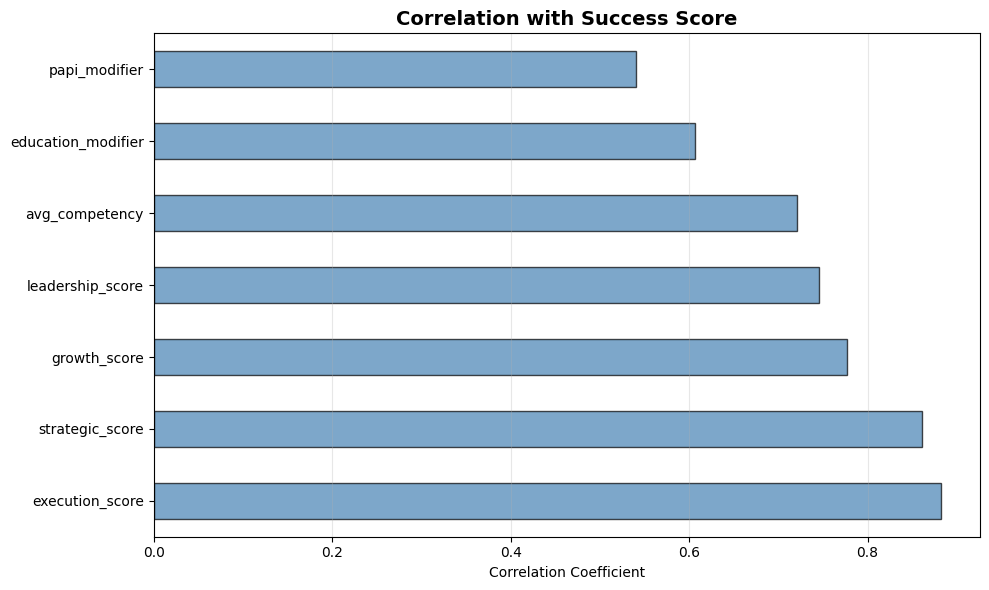

,execution_score,strategic_score,growth_score,leadership_score
execution_score,1.00,0.75,0.68,0.70
strategic_score,0.75,1.00,0.69,0.71
growth_score,0.68,0.69,1.00,0.65
leadership_score,0.70,0.71,0.65,1.00


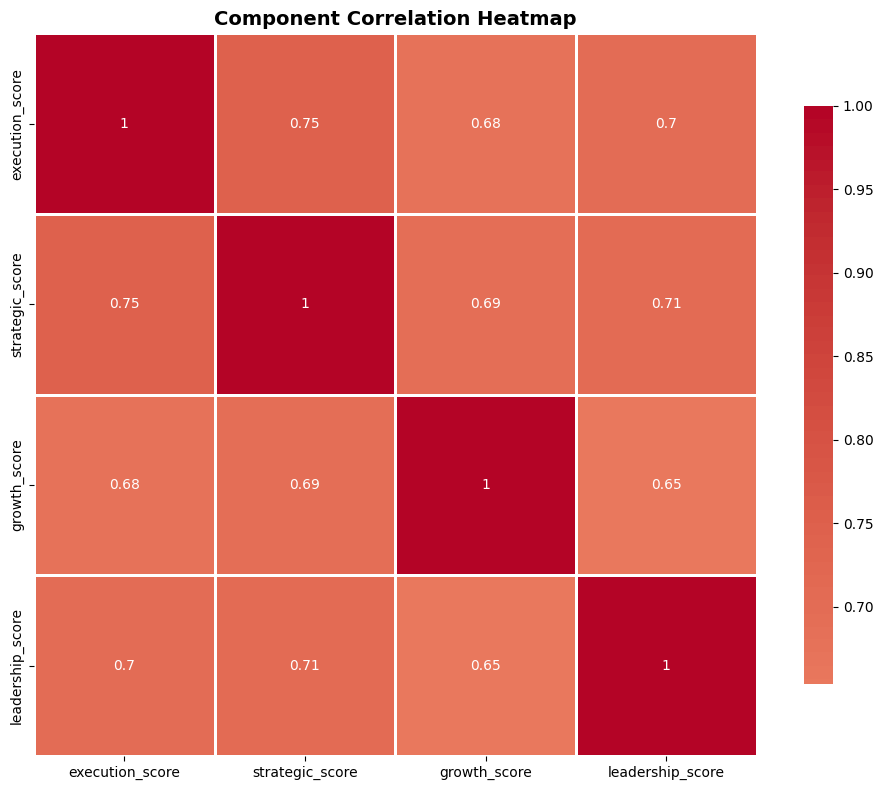

In [47]:
# Correlation with success score
corr_cols = component_cols + ['education_modifier', 'papi_modifier', 'avg_competency']
correlations = df_valid[corr_cols + ['success_score']].corr()['success_score'].sort_values(ascending=False)
print(correlations[1:])  # Exclude self-correlation

# Visualize correlation
plt.figure(figsize=(10, 6))
correlations[1:].plot(kind='barh', color='steelblue', alpha=0.7, edgecolor='black')
plt.title('Correlation with Success Score', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Component correlation matrix
comp_corr = df_valid[component_cols].corr()
display(comp_corr.round(2))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(comp_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Component Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Scenario ANalysis

In [48]:
# Create a sample employee for scenario testing
sample_employee = pd.Series({
    'Quality_Delivery': 4.0,
    'Social_Empathy': 4.0,
    'Commercial_Savvy': 4.0,
    'Growth_Drive': 4.0,
    'Value_Creation': 4.0,
    'Curiosity': 4.0,
    'Lead_Inspire': 4.0,
    'Insight_Decision': 4.0,
    'Forward_Thinking': 4.0,
    'Team_Orientation': 4.0,
    'avg_competency': 4.0,
    'degree_level': 'S1',
    'Papi_P': 6,
    'Papi_W': 6
})

print("\nBASELINE SCENARIO:")
print("   All competencies = 4.0")
print("   Education = S1")
print("   PAPI_P = 6, PAPI_W = 6")

baseline_result = calculate_success_score(sample_employee)
print(f"\n   Success Score: {baseline_result['success_score']}")
print(f"   Profile: {baseline_result['profile']}")

# Scenario 1: Improve Quality to 4.5
print("\nSCENARIO 1: Improve Quality_Delivery to 4.5")
scenario1 = sample_employee.copy()
scenario1['Quality_Delivery'] = 4.5
result1 = calculate_success_score(scenario1)
print(f"   Success Score: {result1['success_score']} (Δ {result1['success_score'] - baseline_result['success_score']:.2f})")
print(f"   Execution Score: {result1['execution_score']} (synergy bonus activated!)")

# Scenario 2: Improve Quality + Forward Thinking
print("\nSCENARIO 2: Improve Quality_Delivery to 4.5 + Forward_Thinking to 4.5")
scenario2 = sample_employee.copy()
scenario2['Quality_Delivery'] = 4.5
scenario2['Forward_Thinking'] = 4.5
scenario2['avg_competency'] = 4.05
result2 = calculate_success_score(scenario2)
print(f"   Success Score: {result2['success_score']} (Δ {result2['success_score'] - baseline_result['success_score']:.2f})")
print(f"   Execution Score: {result2['execution_score']} (higher synergy!)")

# Scenario 3: Strategic cluster improvement
print("\nSCENARIO 3: Improve Strategic Cluster (Commercial + Insight + Value to 4.5)")
scenario3 = sample_employee.copy()
scenario3['Commercial_Savvy'] = 4.5
scenario3['Insight_Decision'] = 4.5
scenario3['Value_Creation'] = 4.5
scenario3['avg_competency'] = 4.15
result3 = calculate_success_score(scenario3)
print(f"   Success Score: {result3['success_score']} (Δ {result3['success_score'] - baseline_result['success_score']:.2f})")
print(f"   Strategic Score: {result3['strategic_score']} (strategic leader bonus!)")

print("\nKey Insights:")
print("   Synergy effects create non-linear improvements!")
print("   Focusing on related competencies together yields higher returns than isolated improvements.")


BASELINE SCENARIO:
   All competencies = 4.0
   Education = S1
   PAPI_P = 6, PAPI_W = 6

   Success Score: 4.47
   Profile: Emerging High Performer

SCENARIO 1: Improve Quality_Delivery to 4.5
   Success Score: 4.69 (Δ 0.22)
   Execution Score: 5.0 (synergy bonus activated!)

SCENARIO 2: Improve Quality_Delivery to 4.5 + Forward_Thinking to 4.5
   Success Score: 4.77 (Δ 0.30)
   Execution Score: 5.2 (higher synergy!)

SCENARIO 3: Improve Strategic Cluster (Commercial + Insight + Value to 4.5)
   Success Score: 4.86 (Δ 0.39)
   Strategic Score: 5.62 (strategic leader bonus!)

Key Insights:
   Synergy effects create non-linear improvements!
   Focusing on related competencies together yields higher returns than isolated improvements.


# SUCCESS FORMULA STRUCTURE

## LAYER 1: FOUNDATION GATES (Gate-Keeping)

**Critical Competencies (ALL must be >= 3.0):**
- Quality Delivery
- Commercial Savvy
- Social Empathy

**FAIL:** Max Score = 3.5 (Cannot reach Rating 5)

---

## LAYER 2: COMPETENCY SYNERGY CLUSTERS (80% weight)

### A. Execution Excellence (35% weight)
**Components:** Quality + Forward Thinking + Team Orientation  

**Synergy Rules:**
- IF Quality >= 4.5 AND Forward Thinking >= 4.0 → Multiplier = 1.2
- ELSE IF All components >= 4.0 → Multiplier = 1.1
- ELSE → Multiplier = 1.0

### B. Strategic Impact (30% weight)
**Components:** Commercial + Insight + Value Creation  

**Synergy Rules:**
- IF Commercial >= 4.5 AND Insight >= 4.3 AND Value Creation >= 4.5 → Multiplier = 1.25
- ELSE IF Commercial >= 4.0 AND (Insight >= 4.0 OR Value Creation >= 4.0) → Multiplier = 1.1
- ELSE → Multiplier = 1.0

### C. Growth & Innovation (25% weight)
**Components:** Growth Drive + Curiosity  

**Synergy Rules:**
- IF Both >= 4.5 → Multiplier = 1.3
- ELSE → Multiplier = 1.0

### D. People Leadership (10% weight)
**Components:** Lead/Inspire + Social Empathy  

**Synergy Rules:**
- IF Both >= 4.5 → Multiplier = 1.2
- ELSE → Multiplier = 1.0

---

## LAYER 3: CONTEXTUAL AMPLIFIERS

### A. Education Modifier (15% weight)
- S2 + Avg Competency >= 4.5 → × 1.15 (fully leveraged)
- SMA + Avg Competency >= 4.5 → × 1.10 (overperformer)
- S2 + Avg Competency < 4.0 → × 1.02 (underutilized)
- S1 or SMA → × 1.05
- D3 → × 1.03
- Other → × 1.0

### B. PAPI Personality Alignment (5% weight)
- High Papi_P (>=7) + High Quality (>=4.5) → × 1.08
- High Papi_W (>=6) + High Leadership (>=4.5) → × 1.06
- ELSE → × 1.0

---

## FINAL CALCULATION

**Step 1: Base Score**  
Base Score = (Execution × 0.35) + (Strategic × 0.30) + (Growth × 0.25) + (Leadership × 0.10)

**Step 2: Apply Modifiers**  
Final Score = Base Score × Education Modifier × PAPI Modifier

**Step 3: Cap Maximum**  
Final Score = MIN(Final Score, 5.0)

---

## INTERPRETATION

- Score >= 4.7 → Top Performer Profile  
- Score 4.0 - 4.6 → Emerging High Performer  
- Score < 4.0 → Developing Performer  
- Foundation Fail → Foundation Gap (Max 3.5)

---

# STATISTICAL JUSTIFICATION

**INCLUDED (Strong Statistical Signal):**
- Competencies: All p < 0.001, Gap: 1.60-1.76 → 80% weight
- Education: p = 0.02, effect size moderate → 15% weight
- PAPI: Weak correlation (<0.04) → 5% weight only

**EXCLUDED (No Statistical Signal):**
- Duration: p = 0.45
- DISC: All p > 0.05
- Cognitive (IQ/GTQ): Overlapping distributions
- Strengths: p = 0.98
- Major: p = 0.21